In [54]:
import os
import cv2
import numpy as np
from glob import glob
import pprint
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import random
from BEV.bev_transform import BEV

# Data generation

In [55]:
HUMAN_DATASET_ROOT = Path('data/human_dataset_filtered/')
RZD_DATASET_ROOT = Path('/dataset/rzd/rostov/')

In [135]:
# dest_image_name = 'Mon_Nov_16_163751_2020/camera1/img_174124862194.png'

dest_image_name = 'Sun_Nov__8_141316_2020/camera1/img_900983.png'
SOURCE_IMAGES = sorted(list(HUMAN_DATASET_ROOT.glob('*image.png')))
SOURCE_MASKS = sorted(list(HUMAN_DATASET_ROOT.glob('*mask.png')))

dest_image_name = RZD_DATASET_ROOT / dest_image_name
image = cv2.imread(str(dest_image_name))

In [136]:
def show_image(image):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    plt.title('city_image')
    plt.show()


def resize_keep_ar(image, height=500):
    r = height / float(image.shape[0])
    width = r * image.shape[1]  
    image = cv2.resize(image, (int(width), int(height)))
    return image


def paste_object(image_dst, image_src, mask_src, x_coord, y_coord, random_h_flip=True):
    src_h, src_w, _ = image_src.shape
    dst_h, dst_w, _ = image_dst.shape
    x_offset, y_offset = x_coord-int(src_w/2), y_coord-src_h
    y1, y2 = max(y_offset, 0), min(y_offset + src_h, dst_h)
    x1, x2 = max(x_offset, 0), min(x_offset + src_w, dst_w)
    y1_m = 0 if y1>0 else -y_offset
    x1_m = 0 if x1>0 else -x_offset
    y2_m = src_h if y2<dst_h-1 else dst_h - y_offset 
    x2_m = src_w if x2<dst_w-1 else dst_w - x_offset
    
    if y1_m>=src_h or x1_m>=src_w or y2_m<0 or x2_m<0:
        return image_dst
    
    if random_h_flip:
        if random.uniform(0, 1)>0.5:
            image_src = cv2.flip(image_src, 1)
            mask_src = cv2.flip(mask_src, 1)
        
    mask_inv = cv2.bitwise_not(mask_src)
    img1_bg = cv2.bitwise_and(image_dst[y1:y2, x1:x2],image_dst[y1:y2, x1:x2],mask=mask_inv[y1_m:y2_m, x1_m:x2_m])
    img2_fg = cv2.bitwise_and(image_src[y1_m:y2_m, x1_m:x2_m],image_src[y1_m:y2_m, x1_m:x2_m],mask=mask_src[y1_m:y2_m, x1_m:x2_m])
    out_img = cv2.add(img1_bg,img2_fg)

    image_dst[y1:y2, x1:x2] = out_img

#     kernel = np.ones((5,5),np.uint8)
#     mask_src = cv2.dilate(mask_src, kernel,iterations=2)
#     src_h, src_w, _ = image_src.shape
#     center = (x_coord-int(src_w/2), y_coord-int(src_h/2))
#     image_dst = cv2.seamlessClone(image_src, image_dst, mask_src, center, cv2.NORMAL_CLONE)
    
    return image_dst


def select_images(source_images, source_masks, person_idx):
    source_image_path = source_images[person_idx]
    source_mask_path  = source_masks[person_idx]
    image_src = cv2.imread(str(source_image_path))
    mask_src = cv2.imread(str(source_mask_path),0)
    return image_src, mask_src


def generate_objects_coord(image, source_images, source_masks, points, heights, persons_idxs=None, random_h_flip=True):
    n_persons = points.shape[0]
    if persons_idxs is None:
        persons_idxs = [random.randint(0,len(SOURCE_IMAGES)) for _ in range(n_persons)]
    
    assert len(persons_idxs)==points.shape[0] and points.shape[0]==heights.shape[0]
    
    image_dst = image.copy()

    print(f'generate {n_persons} persons')
    for person_idx, point, height in zip(persons_idxs, points, heights):
        x_coord, y_coord = int(point[0]), int(point[1]) 
        image_src, mask_src = select_images(source_images, source_masks, person_idx)
        image_src_resized = resize_keep_ar(image_src, height)
        mask_src_resized = resize_keep_ar(mask_src, height)
        image_dst = paste_object(image_dst, image_src_resized, mask_src_resized, x_coord, y_coord, random_h_flip)
        
    return image_dst


def generate_objects_random(image, source_images, source_masks, min_n_objects=1, 
                                                         max_n_objects=6,
                                                         h_range=[40, 100],
                                                         x_range=[250, 1500],
                                                         y_range=[600 ,1000],
                                                         persons_idxs=None,
                                                         random_h_flip=True):
    '''
    Same as generate_objects_coord
    '''
    n_persons = random.randint(min_n_objects, max_n_objects)
    points = np.random.randint(low=[x_range[0], y_range[0]], 
                               high=[x_range[1], y_range[1]], 
                               size=(n_persons,2))
    heights = np.random.randint(low=h_range[0], 
                                high=h_range[1], 
                                size=(n_persons,1))
        
    return generate_objects_coord(image, source_images, source_masks, points, heights, persons_idxs, random_h_flip)


def generate_objects_bev_coord(image, bev_transform, source_images, source_masks, points, heights, persons_idxs=None, random_h_flip=True):
    '''
        points - numpy array of coordinates in meters with shape [n,2]
    '''
    n_persons = points.shape[0]
    
    if persons_idxs is None:
        persons_idxs = [random.randint(0,len(SOURCE_IMAGES)) for _ in range(n_persons)]
    
    assert len(persons_idxs)==points.shape[0] and points.shape[0]==heights.shape[0]
    
    image_dst = image.copy()
    
    points_pixels = bev_transform.meters_to_pixels(points)
    distances = bev_transform.calculate_dist_meters(points)
    d_sorted_idxs = np.argsort(distances)[::-1]
    distances = distances[d_sorted_idxs]
    heights = heights[d_sorted_idxs]
    points_pixels = points_pixels[d_sorted_idxs]
    
    print(f'generate {n_persons} persons')
    for person_idx, point, height, distance in zip(persons_idxs, points_pixels, heights, distances):
        image_src, mask_src = select_images(source_images, source_masks, person_idx)
        x_coord, y_coord = int(point[0]), int(point[1])
        
        height_pixels = bev_transform.get_height_in_pixels(height, distance)
        image_src_resized = resize_keep_ar(image_src, height=height_pixels)
        mask_src_resized = resize_keep_ar(mask_src, height=height_pixels)
        image_dst = paste_object(image_dst, image_src_resized, mask_src_resized, x_coord, y_coord,random_h_flip)
        
    return image_dst


def generate_objects_bev_random(image, bev_transform, source_images, source_masks, min_n_objects=1, 
                                                                                         max_n_objects=6,
                                                                                         h_range=[1.8, 3],
                                                                                         x_range=[-10, 10],
                                                                                         y_range=[10 ,100],
                                                                                         persons_idxs=None,
                                                                                         random_h_flip=True):
    n_persons = random.randint(min_n_objects, max_n_objects)
    points = np.random.uniform(low=[x_range[0], y_range[0]], high=[x_range[1], y_range[1]], size=(n_persons,2))
    heights = np.random.uniform(low=h_range[0], high=h_range[1], size=(n_persons,1))
      
    return generate_objects_bev_coord(image, bev_transform, source_images, source_masks, points, heights, persons_idxs, random_h_flip) 

generate 2 persons


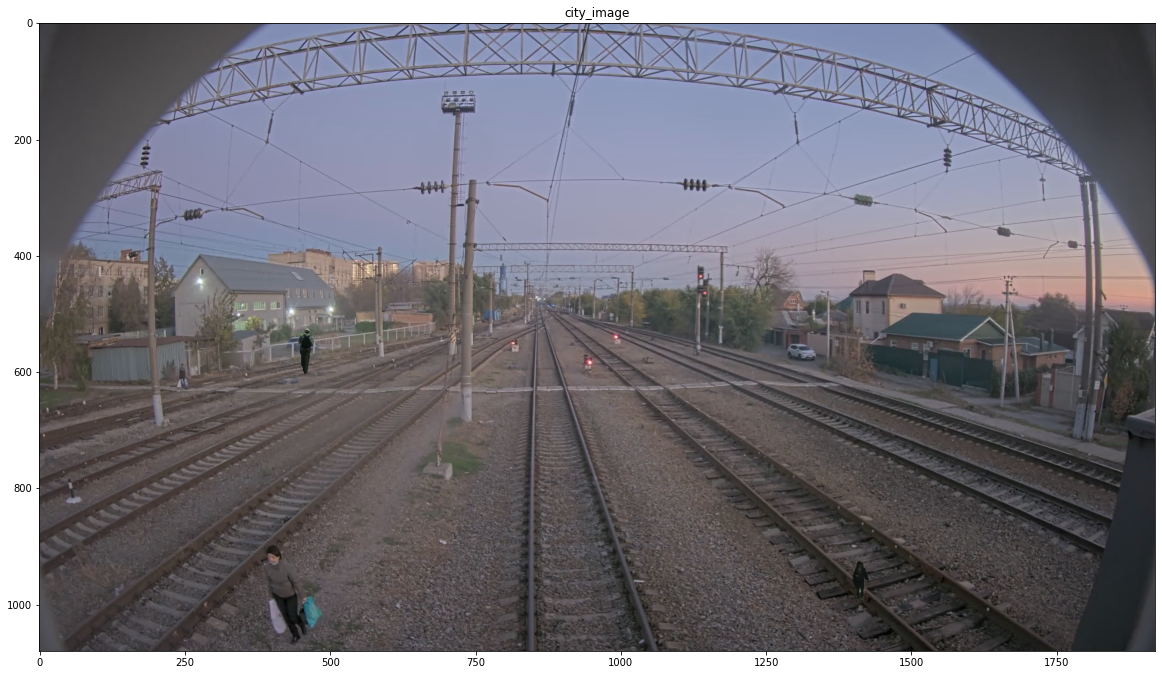

In [137]:
result_image = generate_objects_random(image, SOURCE_IMAGES, SOURCE_MASKS)
result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
show_image(result_image)

# BEV

In [129]:
bev_transform = BEV()

In [138]:
RZD_DATASET_ROOT = Path('/dataset/rzd/rostov/')
# dest_image_name = 'Mon_Nov_16_163751_2020/camera1/img_174124862194.png'

dest_image_name = 'Sun_Nov__8_141316_2020/camera1/img_900983.png'
dest_image_name = RZD_DATASET_ROOT / dest_image_name
img = cv2.imread(str(dest_image_name))

img_bev = bev_transform(img)

In [139]:
points = np.array([[0,10],[5,10], [-5.3,10], [0,50]])
heights = np.array([2.5, 2.3, 2.1,2.1])

generate 4 persons


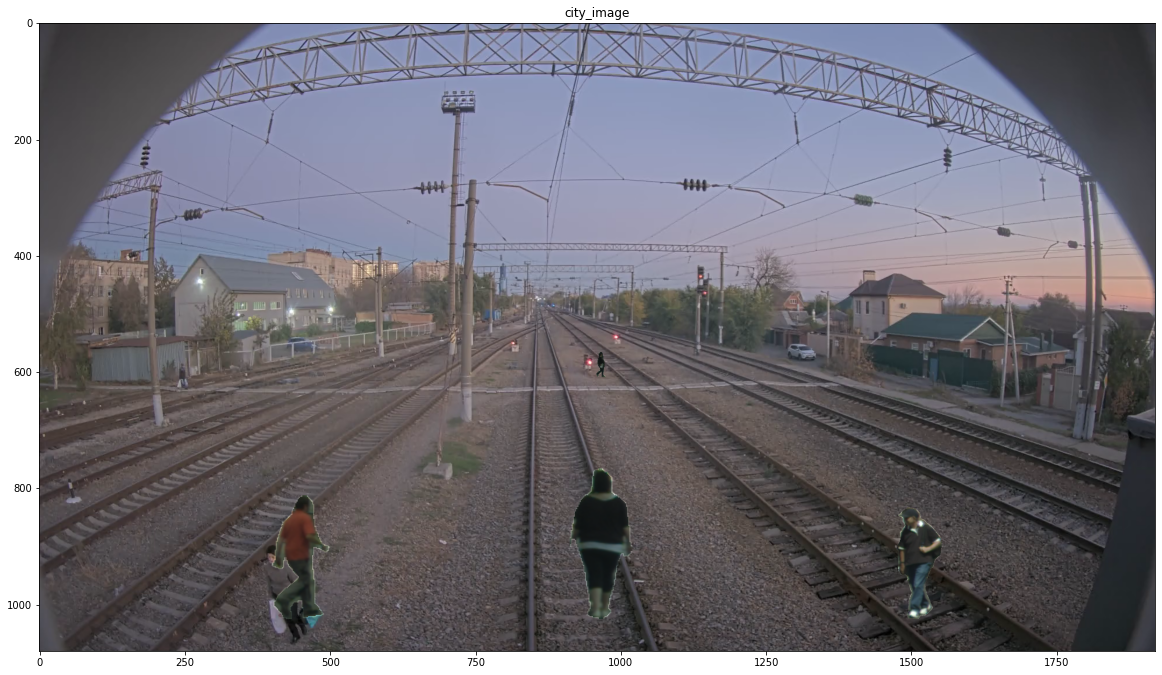

In [140]:
result_image = generate_objects_bev_coord(image, bev_transform, SOURCE_IMAGES, SOURCE_MASKS, points, heights)
result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
show_image(result_image)

generate 14 persons


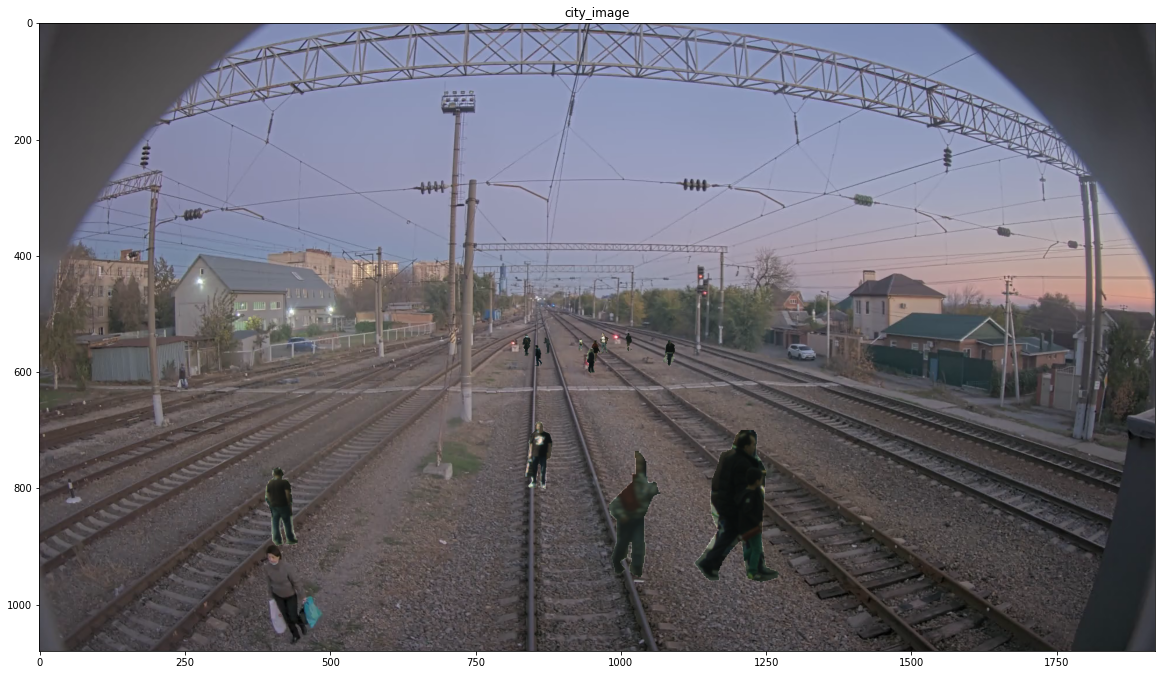

In [143]:
result_image = generate_objects_bev_random(image, bev_transform, SOURCE_IMAGES, SOURCE_MASKS, min_n_objects=10, 
                                                                                         max_n_objects=15)
result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
show_image(result_image)